In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import risk_kit as rk
import pandas as pd
import numpy as np
ind = rk.get_ind_returns()
er = rk.annualize_ret(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ind_returns = rk.get_ind_returns()
ind_nfirms = rk.get_ind_nfirms()
ind_size = rk.get_ind_size()

In [7]:
#tmi_return = rk.get_total_market_index_return()

In [8]:
ind_mktcap = ind_nfirms * ind_size
total_mktcap  = ind_mktcap.sum(axis='columns')
ind_capweight = ind_mktcap.divide(total_mktcap, axis='rows')
total_market_return = (ind_capweight * ind_returns).sum(axis='columns')
total_market_index = rk.compute_drawdown(total_market_return).Wealth
total_market_index.head(2)

1926-07    1031.375211
1926-08    1061.241004
Freq: M, Name: Wealth, dtype: float64

In [10]:
risky_r = ind_returns['2000':][['Steel', 'Fin', 'Beer']]

In [11]:
risky_r.shape

(228, 3)

In [14]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [15]:
safe_r.shape

(228, 3)

In [17]:
safe_r[:] = 0.03 / 12
start = 1000
floor = 0.8

1. Cushion - (Asset Value minus Floor Value)
2. Compute an Allocation to Safe and Risk Assets --> m * risk budget
3. Recompute the Asset Value based on the returns

In [50]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor 
m = 3

account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    
    # update the account value for this time step
    account_value = risky_alloc *(1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    
    # save values to look at the history 
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    

In [51]:
n_steps

228

In [52]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


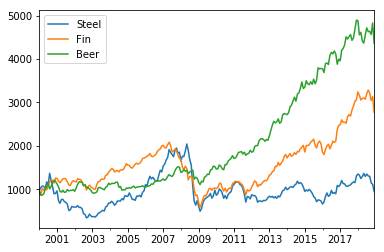

In [53]:
risky_wealth = start * (1 + risky_r).cumprod()
risky_wealth.plot()

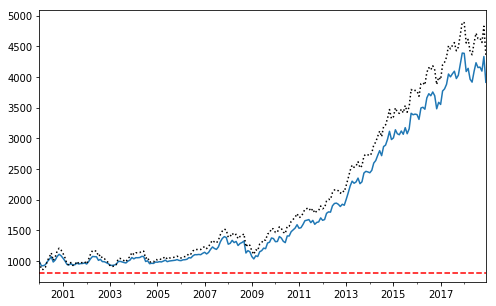

In [55]:
ax = account_history['Beer'].plot(figsize=(8,5))
risky_wealth['Beer'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

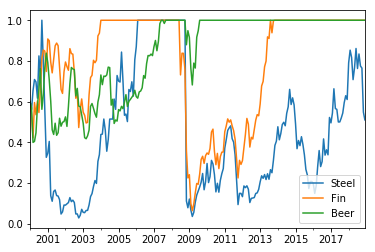

In [56]:
risky_w_history.plot()

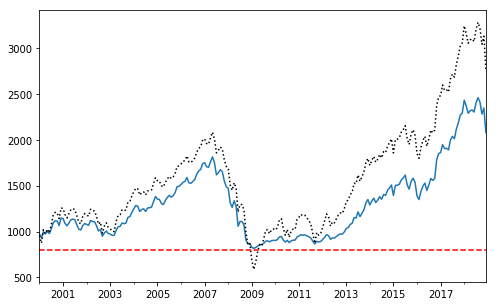

In [57]:
ax = account_history['Fin'].plot(figsize=(8,5))
risky_wealth['Fin'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

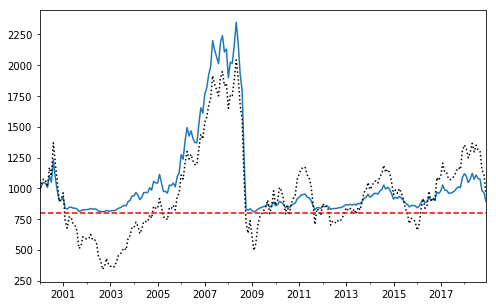

In [58]:
ax = account_history['Steel'].plot(figsize=(8,5))
risky_wealth['Steel'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

In [72]:
btr = rk.run_ccpi(risky_r)
btr['Wealth'].pct_change().dropna().head()
                  

,Steel,Fin,Beer
2000-02,0.039530,-0.044447,-0.065175
2000-03,0.023710,0.071974,0.002020
2000-04,-0.005228,-0.024304,0.016390
2000-05,-0.033530,0.028270,0.054417
2000-06,0.095545,-0.023209,0.036056


### Drawdown Constraint

In [82]:
btr = rk.run_ccpi(ind_returns['2007':][['Steel', 'Fin', 'Beer']], drawdown = 0.25)

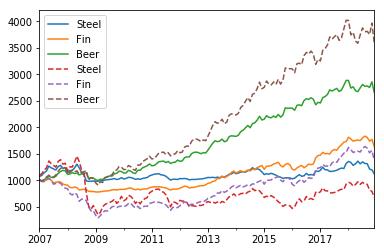

In [83]:
ax = btr['Wealth'].plot()
btr['Risky Wealth'].plot(ax=ax, style = '--')

### Testing different for loops

In [31]:
def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [25]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [26]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [28]:
%timeit compound1(risky_r)

1.33 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
%timeit compound2(risky_r)

368 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
